[](https://colab.research.google.com/github/davalpez/MyKaggle/blob/MyKaggle/InsuranceRegression/InsuranceRegression.ipynb)

# Lineal Regression model for Insurance Cost Personal Dataset


## Notebook Outline

1. **Initil setup and libraries** \
    Load libraries and check python and library versions. Check GPU usage.
2. **Data preparation** \
    Data cleaning and column re-distribution for an effective regression model training.
3. **Exploratory analysis** \
    Analysis characteristics of the dataset and correlation between variables
4. **Building regression model** \
    Building a simple regression model and a normalized trained model.

## 1. Initial setup and libraries

In this notebook, we are going to examine the [Medical Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance) from kaggle an stablish a lineal regression model to predict charges based onn other features contain in this datased, such as age, gender, bmi and other personal characteristics.


In [108]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
import sys

print(sys.version)

3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [110]:
%pip list | grep -E 'tensorflow|pandas|numpy|seaborn'

numpy                     1.26.4
pandas                    2.2.3
seaborn                   0.13.2
tensorflow                2.19.0
tensorflow-hub            0.16.1
Note: you may need to restart the kernel to use updated packages.


In [111]:
!nvidia-smi

Fri Jul 18 14:45:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   73C    P0             25W /   80W |    6462MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [112]:
# Import tensorflow and confirm the GPU availability.
import tensorflow as tf
tf.config.set_soft_device_placement(True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [113]:
dataset = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

## 2. Data Preparation

We take a look at how the features of this dataset look like.

In [114]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [115]:
len(dataset)

1338

First step when we have a diverse and large dataset like this one, we have to mind two things:

1. Clear the dataset, by examining if there are unknown values that can missdirect our predictions.

2. Adapt the features so our model can predict more efficiently. 

Let's start by checking if we need to `clear the dataset`.

In [116]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We confirm that for children we have a integer value so we consider that column of the dataset as full numbers, not a float.

In [117]:
dataset['children']

0       0
1       1
2       3
3       0
4       0
       ..
1333    3
1334    0
1335    0
1336    0
1337    0
Name: children, Length: 1338, dtype: int64

For the `smoker`column, we can turn the string data into boolean data. Same with `sex`, adjusting i.e. female = 0 and male = 1.

In [118]:
dataset['smoker'] = dataset['smoker'].map({'yes': 1, 'no': 0})
dataset['sex'] = dataset['sex'].map( {'male': 1, 'female': 0})
dataset.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,1,30.97,3,0,northwest,10600.5483
1334,18,0,31.92,0,0,northeast,2205.9808
1335,18,0,36.85,0,0,southeast,1629.8335
1336,21,0,25.80,0,0,southwest,2007.9450
1337,61,0,29.07,0,1,northwest,29141.3603


Smoker and Sex columns should be column as they are categorical values

In [119]:
dataset['smoker'] = dataset['smoker'].astype(bool)
dataset['sex'] = dataset['sex'].astype(bool)

The dataset looks clear as it does not have any NaN values.
We can continue now by `adapting the features`. What does this mean? 

`Region` column for example has categorical (not numerical) values. We can adapt this features using [data encoding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding). There are different types of hot encoding, we are going to use one hot encoding.

In [120]:
np.unique(dataset['region'])

array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

In [121]:
dataset_copy = dataset
dataset = pd.get_dummies(dataset, columns=['region'], prefix='', prefix_sep='')
dataset.tail()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
1333,50,True,30.97,3,False,10600.5483,False,True,False,False
1334,18,False,31.92,0,False,2205.9808,True,False,False,False
1335,18,False,36.85,0,False,1629.8335,False,False,True,False
1336,21,False,25.80,0,False,2007.9450,False,False,False,True
1337,61,False,29.07,0,True,29141.3603,False,True,False,False


In [122]:
dataset.tail()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
1333,50,True,30.97,3,False,10600.5483,False,True,False,False
1334,18,False,31.92,0,False,2205.9808,True,False,False,False
1335,18,False,36.85,0,False,1629.8335,False,False,True,False
1336,21,False,25.80,0,False,2007.9450,False,False,False,True
1337,61,False,29.07,0,True,29141.3603,False,True,False,False


Now that we have clear de data, we split the data into features and labels and into a train and test dataset.

In [123]:
def Split_dataset(dataset):
    """
    Splits the dataset into training and testing sets with an 80/20 ratio.
    The 'charges' column is treated as the target variable.

    we could achieve the same with " sklearn.model_selection > train_test_split"

    Returns:
        train_features: Features for training
        train_labels: Labels for training ('charges')
        test_features: Features for testing
        test_labels: Labels for testing ('charges')
    """
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    train_features = train_dataset.copy()
    train_labels = train_features.pop('charges')

    test_features = test_dataset.copy()
    test_labels = test_features.pop('charges')

    return train_features,train_labels,test_features,test_labels

train_features,train_labels,test_features,test_labels =  Split_dataset(dataset)


In [124]:
train_features.head()

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest
578,52,True,30.200,1,False,False,False,False,True
610,47,False,29.370,1,False,False,False,True,False
569,48,True,40.565,2,True,False,True,False,False
1034,61,True,38.380,0,False,False,True,False,False
198,51,False,18.050,0,False,False,True,False,False


## 3. Doing a exploratory analysis

Let's verify the data types we have ended with in our dataset after the changes we have done : 
* Age(int): defines the age of the beneficiary.
* Sex(bool): defines the sex of the beneficiary(woman=false,man=true).
* bmi(float): defines body mass index.
* children(int): defines number of children that the beneficiary has.
* smoker(bool): defines if the beneficiary is a smoker.
* region: defines on four bool-state the beneficiary's residential area.
* charges(float): insurace cost for the beneficiary.

In [125]:
dataset.dtypes

age            int64
sex             bool
bmi          float64
children       int64
smoker          bool
charges      float64
northeast       bool
northwest       bool
southeast       bool
southwest       bool
dtype: object

Let's see how the cost of the insurance correlates with the rest of the variables and build a correlation matrix.

In [126]:
correlation = dataset.corr()
correlation['charges'].sort_values()


southwest   -0.043210
northwest   -0.039905
northeast    0.006349
sex          0.057292
children     0.067998
southeast    0.073982
bmi          0.198341
age          0.299008
smoker       0.787251
charges      1.000000
Name: charges, dtype: float64

<Axes: >

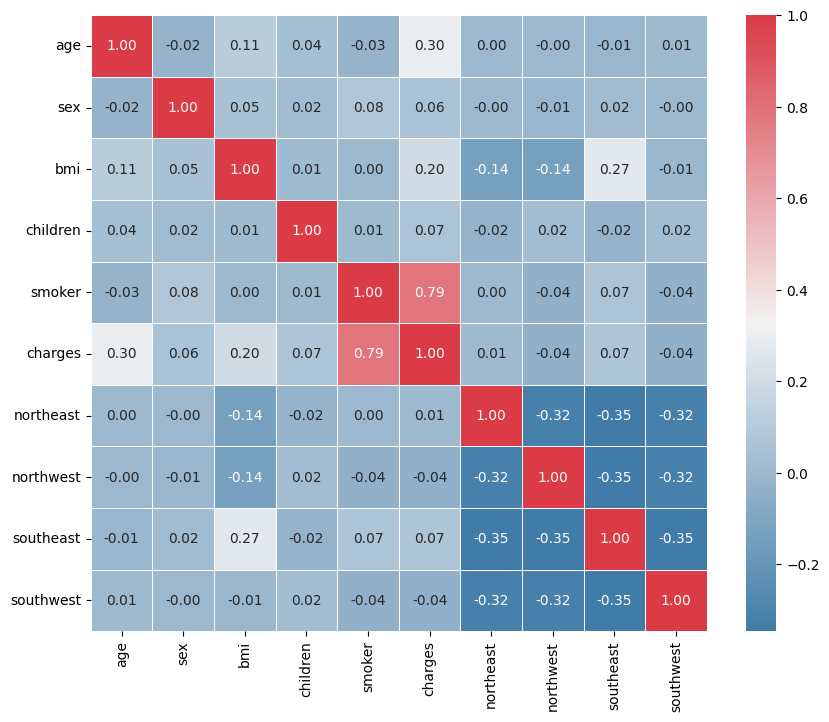

In [127]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation, cmap=sns.diverging_palette(240, 10, as_cmap=True),
            square=True, annot=True, fmt=".2f", linewidths=0.5, ax=ax)

We can see from a quick analysis that the variable that has the higher correlation for the price of the insurance is smoker.

Let's now check some of the data distribution for some of these key variables against the amount charged for them.

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

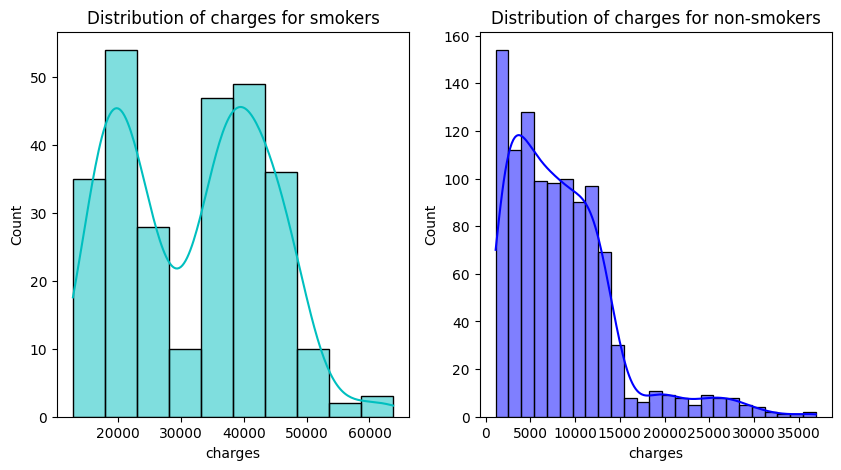

In [128]:
figure = plt.figure(figsize=(10,5))

ax = figure.add_subplot(121)
sns.histplot(dataset[dataset.smoker == True]["charges"], color='c', kde=True, ax=ax)
ax.set_title('Distribution of charges for smokers')

ax = figure.add_subplot(122)
sns.histplot(dataset[dataset.smoker == False]["charges"], color='b', kde=True, ax=ax)
ax.set_title('Distribution of charges for non-smokers')


In [129]:
high_charge_smoker = dataset[(dataset.smoker == True) & (dataset.charges > 35000)]["charges"].count()
max_non_smoker = max(dataset[(dataset.smoker == False)]["charges"])
high_charge_smoker,max_non_smoker

(130, 36910.60803)

As we saw from the correlation matrix, being smoker is impacting the amount charged. From these graphs, we can see that non-smokers are not charge beyond 37000, while we have 130 smokers charged over the 35000 limit.

Text(0.5, 1.0, 'Distribution of charges for women')

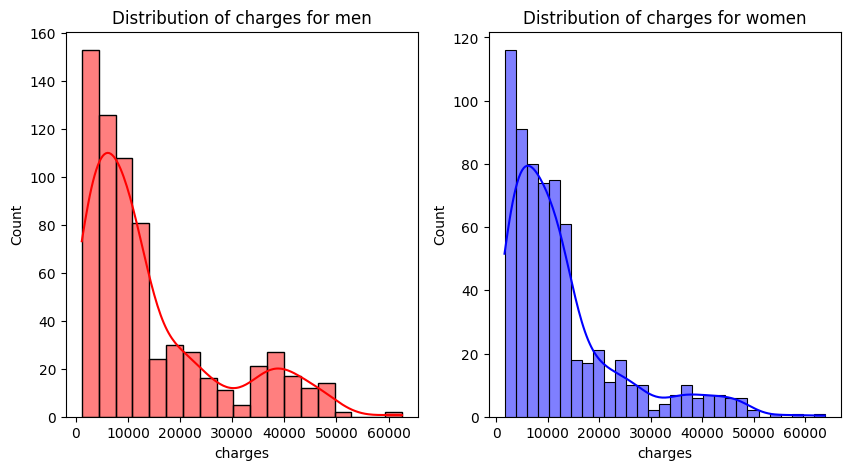

In [130]:
figure = plt.figure(figsize=(10,5))

ax = figure.add_subplot(121)
sns.histplot(dataset[dataset.sex == True]["charges"], color='r', kde=True, ax=ax)
ax.set_title('Distribution of charges for men')

ax = figure.add_subplot(122)
sns.histplot(dataset[dataset.sex == False]["charges"], color='b', kde=True, ax=ax)
ax.set_title('Distribution of charges for women')

In [131]:
from scipy.signal import find_peaks

# Get charges for men
charges_men = dataset[dataset.sex == False]["charges"]

# Find peaks (local maxima) in the histogram
counts, bin_edges = np.histogram(charges_men, bins=30)
peaks, _ = find_peaks(counts)

# Get the bin centers for the peaks
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
local_maxima = bin_centers[peaks]

local_maxima

array([19220.33684117, 25436.62863217, 39941.30947783, 44085.50400517,
       48229.6985325 , 54445.9903235 , 58590.18485083])

We see that the sex probability distribution is quite similar, having for men a local maximum at 39000. Is this change related to smoker/non-smoker? 

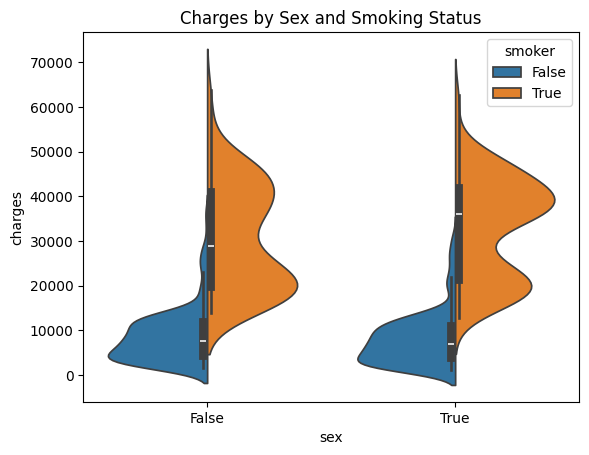

In [132]:
sns.violinplot(x='sex', y='charges', hue='smoker', data=dataset, split=True)
plt.title('Charges by Sex and Smoking Status')
plt.show()

Text(0.5, 1.02, 'Smokers  Age-charge distribution')

<Figure size 1000x500 with 0 Axes>

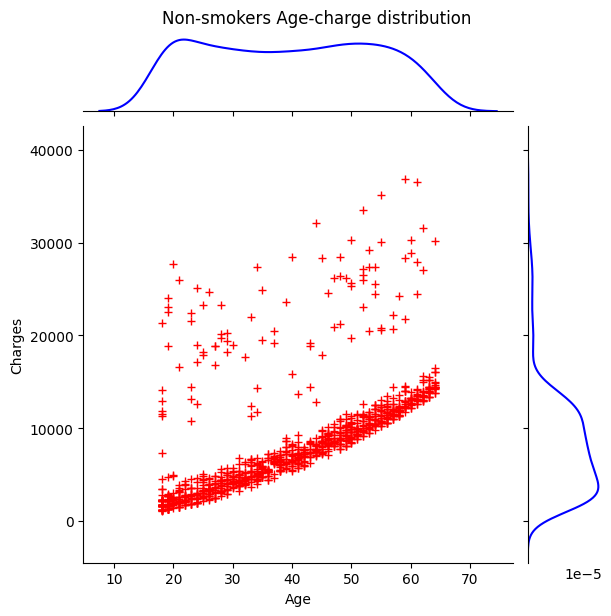

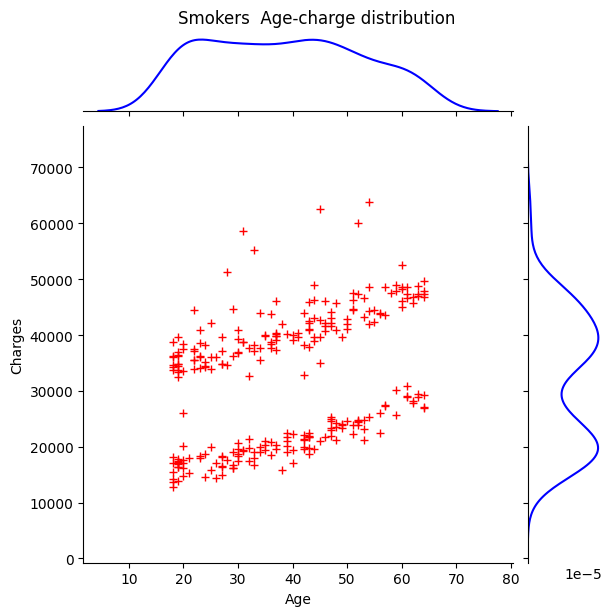

In [133]:

figure = plt.figure(figsize=(10,5))

g1 = sns.jointplot(x="age", y="charges", data=dataset[dataset.smoker == 0], kind="kde", color="b")
g1.plot_joint(plt.scatter , c="r", s=30, linewidth=1, marker="+")
g1.ax_joint.collections[0].set_alpha(0)
g1.set_axis_labels("Age", "Charges")
g1.figure.suptitle('Non-smokers Age-charge distribution', y=1.02)

g2 = sns.jointplot(x="age", y="charges", data=dataset[dataset.smoker == 1], kind="kde", color="b")
g2.plot_joint(plt.scatter , c="r", s=30, linewidth=1, marker="+")
g2.ax_joint.collections[0].set_alpha(0)
g2.set_axis_labels("Age", "Charges")
g2.figure.suptitle('Smokers  Age-charge distribution', y=1.02)

These comparison show some interesting insights as for men, the maximum in the distribution comes from smoker men at around 39000, while for women the highest count comes from the 20000 charge.
Both non-smoker distribution are quire similar for both genders, and therefore similar to the first non-smoker graph we plotted.

We could see from the correlation that smoking was the variable that influenced charge quantities the most, followed by age.

Checking on the age distribution and having the condition of smoker and non-smoker, we can confirm that as the people get older, the quantity charge in the insurance increases. For non-smokers, we can see that the distributions lineary increases with age in a single group with some outliers that are charged higher. For smoker we have two clusters, and we can see how these two clusters follow a linear growth as the beneficiaries grow older.

Let's still check some of the other parameters and how they look against the amount charged to the beneficiaries.

Similar to age, we can see how the BMI of smokers and non-smokers impact the charges for beneficiaries :

Text(0.5, 1.02, 'Smokers  BMI-charge distribution')

<Figure size 1000x500 with 0 Axes>

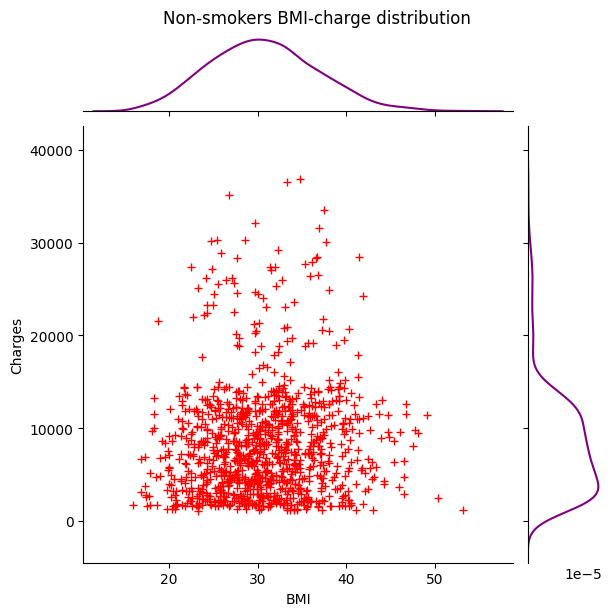

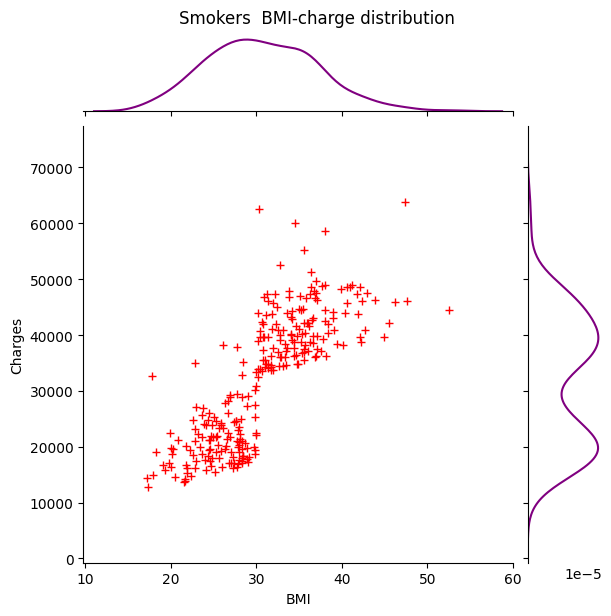

In [134]:

figure = plt.figure(figsize=(10,5))

g1 = sns.jointplot(x="bmi", y="charges", data=dataset[dataset.smoker == 0], kind="kde", color="purple")
g1.plot_joint(plt.scatter , c="r", s=30, linewidth=1, marker="+")
g1.ax_joint.collections[0].set_alpha(0)
g1.set_axis_labels("BMI", "Charges")
g1.figure.suptitle('Non-smokers BMI-charge distribution', y=1.02)

g2 = sns.jointplot(x="bmi", y="charges", data=dataset[dataset.smoker == 1], kind="kde", color="purple")
g2.plot_joint(plt.scatter , c="r", s=30, linewidth=1, marker="+")
g2.ax_joint.collections[0].set_alpha(0)
g2.set_axis_labels("BMI", "Charges")
g2.figure.suptitle('Smokers  BMI-charge distribution', y=1.02)

For non-smoker, we can see that there is some but not a clear correlation as higher BMI doesn't imply higher charges, and we can see how values concentrates between the 20-40 marks and decresases at the ends. For smokers, we can see how there is a positive correlation as the charges linearly grows when the BMI increases. having two sets of clusters that defines a price range depending on the BMI-range of values for smokers.



We also have from a copy of the dataset we did before the original values of the region field. For training a model, it will be more efficient to have them separated in categorical values. But we kept a copy of the dataset with the original values for this parameter to have a better look when doing this exploratory test :

In [135]:
dataset_copy.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,True,30.97,3,False,northwest,10600.5483
1334,18,False,31.92,0,False,northeast,2205.9808
1335,18,False,36.85,0,False,southeast,1629.8335
1336,21,False,25.80,0,False,southwest,2007.9450
1337,61,False,29.07,0,True,northwest,29141.3603


<Axes: xlabel='region', ylabel='charges'>

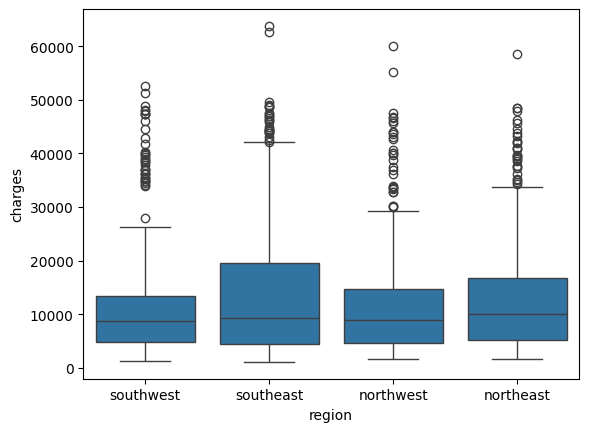

In [136]:
sns.boxplot(x="region", y="charges", data=dataset_copy)

In [137]:
dataset["southwest"].sum(),dataset["southeast"].sum(),dataset["northwest"].sum(),dataset["northeast"].sum()

(325, 364, 325, 324)

We can see that the median for all the regiosn is quite close, so despite i.e. southeast having a higher count distribution for higher charge values, seems to have also high valued outliers but a less amount of them, keeping the median at the same level as other regions.


## 4. Building a regression model to predict charges

### 4.1 Simple model

Now we can try to build a simple model with 2 dense layers made of 100 neurons and 1 output layer. We will train for 100 epochs first and another 100 after.

In [138]:
#insurance_model

# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create our model

insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model

insurance_model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=["mae","mape"])

# 3. Fit the model

history = insurance_model.fit(train_features, train_labels, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 8928.9170 - mae: 8928.9170 - mape: 77.9482
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6315.7031 - mae: 6315.7031 - mape: 35.1078
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5359.2290 - mae: 5359.2290 - mape: 41.3391
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4727.9873 - mae: 4727.9873 - mape: 36.3153
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3970.6326 - mae: 3970.6326 - mape: 26.9535
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4228.6729 - mae: 4228.6729 - mape: 31.9318
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4113.6406 - mae: 4113.6406 - mape: 31.1917
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3684.2766 - mae: 3684.2766 - mape: 25.3313
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4158.1646 - mae: 4158.1646 - mape: 34.3731
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3760.3882 - mae: 3760

In [139]:
# Evaluate
insurance_model_1_loss, insurance_model_1_mae,insurance_model_1_mape =insurance_model.evaluate(test_features, test_labels)
insurance_model_1_loss, insurance_model_1_mae,insurance_model_1_mape

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4025.1179 - mae: 4025.1179 - mape: 24.9745


(4316.1220703125, 4316.1220703125, 25.619985580444336)

As we saved our model into the history variable, we can see how its performance changed over time ( over each epoch).

In [140]:
history.history

{'loss': [7847.95068359375,
  6065.32177734375,
  5385.1904296875,
  4314.9716796875,
  3988.169677734375,
  3963.19677734375,
  3923.514892578125,
  3798.6201171875,
  4397.5234375,
  3827.548583984375,
  3648.546875,
  3635.779052734375,
  3746.747314453125,
  3912.70166015625,
  3555.67236328125,
  3887.797119140625,
  4091.96923828125,
  3737.011474609375,
  4184.81884765625,
  3689.113525390625,
  3957.64013671875,
  4040.147216796875,
  3643.884033203125,
  3779.7255859375,
  3623.505859375,
  3539.33544921875,
  3466.0517578125,
  3601.72412109375,
  4206.94921875,
  3659.93603515625,
  3653.1103515625,
  3726.149658203125,
  3671.53369140625,
  3607.383056640625,
  3659.541748046875,
  3764.668701171875,
  3784.41796875,
  3815.294189453125,
  3750.51220703125,
  3737.369873046875,
  3788.453369140625,
  3615.51171875,
  3838.03173828125,
  3462.284423828125,
  3507.428955078125,
  3507.636962890625,
  3510.282958984375,
  3761.886962890625,
  3390.89111328125,
  3494.296875,
 

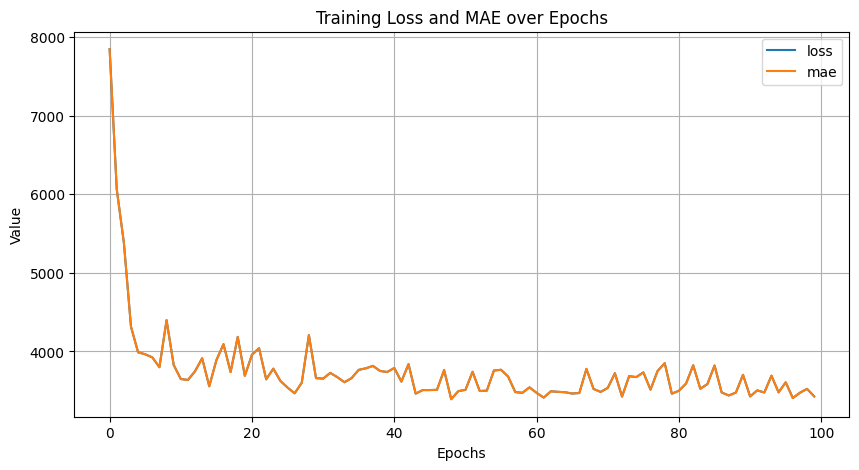

In [141]:
def plot_loss(history):
    history_df = pd.DataFrame(history.history)
    metrics_to_plot = [metric for metric in ['loss', 'mae'] if metric in history_df.columns]
    history_df[metrics_to_plot].plot(figsize=(10, 5))
    plt.ylabel("Value")
    plt.xlabel("Epochs")
    plt.title("Training Loss and MAE over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_loss(history)

In [142]:

# Try training for a little longer (100 more epochs)
history_2 = insurance_model.fit(train_features, train_labels, epochs=100, verbose=0)

In [143]:
insurance_model_2_loss, insurance_model_2_mae,insurance_model_2_mape = insurance_model.evaluate(test_features, test_labels)
insurance_model_2_loss, insurance_model_2_mae,insurance_model_2_mape

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4136.4355 - mae: 4136.4355 - mape: 27.8989 


(4405.29931640625, 4405.29931640625, 28.376354217529297)

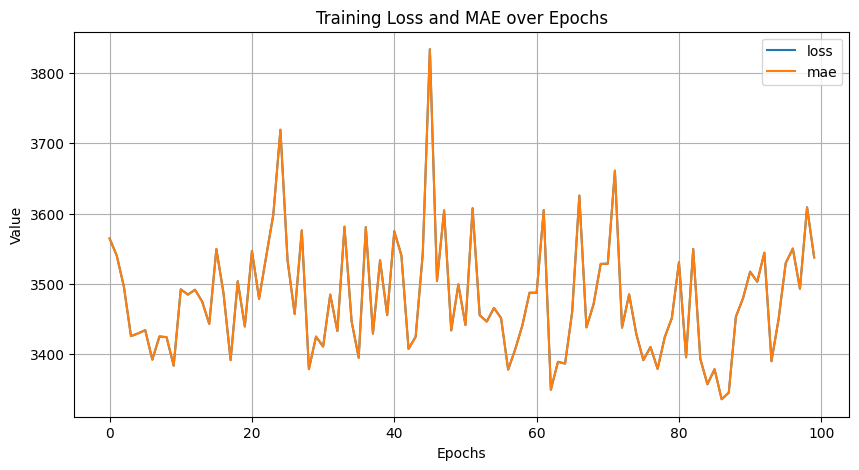

In [144]:
plot_loss(history_2)

### 4.2 Min-max scaled model

#### 4.2.1 Normalized feautres and labels
Let's now build another model where we can min-max scaled our numerical parameters. Min-max scaling normally help the model to learn more confidently as NN tend to perform better when the values are more concentrated between a close range.

In [145]:
dataset.head(10)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,False,27.900,0,True,16884.92400,False,False,False,True
1,18,True,33.770,1,False,1725.55230,False,False,True,False
2,28,True,33.000,3,False,4449.46200,False,False,True,False
3,33,True,22.705,0,False,21984.47061,False,True,False,False
4,32,True,28.880,0,False,3866.85520,False,True,False,False
5,31,False,25.740,0,False,3756.62160,False,False,True,False
6,46,False,33.440,1,False,8240.58960,False,False,True,False
7,37,False,27.740,3,False,7281.50560,False,True,False,False
8,37,True,29.830,2,False,6406.41070,True,False,False,False
9,60,False,25.840,0,False,28923.13692,False,True,False,False


We will use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) function provided by sklearn. We will make a transformer that will ignore our categorical features but minmax the numerical ones.

In [146]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Create column transformer to preprocess all the data.
column_transformer_feature = make_column_transformer(
    (MinMaxScaler(), ["age"]),
    (MinMaxScaler(), [ "bmi"]),
    (MinMaxScaler(), ["children"]), 
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "northeast","northwest","southeast","southwest"])
)

transformer_label = MinMaxScaler()

In [147]:
# Fit column transformer on the training data
column_transformer_feature.fit(train_features)

# Transform training and test data with MinMaxScaler and one hot encoding.
train_features_normalized = column_transformer_feature.transform(train_features)
test_features_normalized = column_transformer_feature.transform(test_features)

train_label_normalized = transformer_label.fit_transform(train_labels.values.reshape(-1, 1))
test_label_normalized = transformer_label.transform(test_labels.values.reshape(-1, 1))

We can take a look on how different we have prepared the data now compared to how we did previously. The main difference we see is that instead of having `sex`and `smoker`as boolean, we have it encoded by hot encoding.

In [148]:
train_features_normalized.shape, train_features.shape

((1070, 15), (1070, 9))

In [149]:
train_features_normalized[0],train_features.loc[0]

(array([0.73913043, 0.38310465, 0.2       , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ]),
 age             19
 sex          False
 bmi           27.9
 children         0
 smoker        True
 northeast    False
 northwest    False
 southeast    False
 southwest     True
 Name: 0, dtype: object)

In [150]:
train_label_normalized.min(),train_label_normalized.max()


(0.0, 1.0)

Checking the values, we can see the transformation has values that make sense. We have ( as organized in the column transform) `age` , `bmi`, `children` and then two columns for `sex` and for column for `origin` one-hot encoded.

We also make the column transformer for the one-hot encoding. This was was working as expected.

We can create another model and try to compare results.

In [151]:
#insurance_model with SK normalization.

# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create our model

insurance_model_scaled= tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model

insurance_model_scaled.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
              metrics=["mae"])

# 3. Fit the model

history_scaled = insurance_model_scaled.fit(train_features_normalized, train_label_normalized, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7123 - mae: 1.7123
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1112 - mae: 0.1112
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0740 - mae: 0.0740
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0666 - mae: 0.0666
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0650 - mae: 0.0650
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0653 - mae: 0.0653
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0638 - mae: 0.0638
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0633 - mae: 0.0633
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0691 - mae: 0.0691
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0677 - mae: 0.0677
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0644 - mae: 0.0644
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0672 - mae: 0.0672
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━

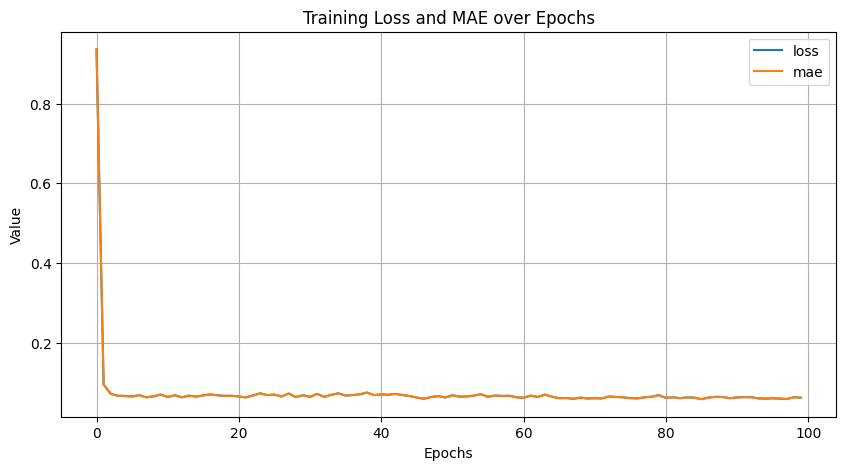

In [152]:
plot_loss(history_scaled)

In [153]:
prediction_normalized = insurance_model_scaled.predict(test_features_normalized)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Unscaling the prediction :

In [154]:
predictions = transformer_label.inverse_transform(prediction_normalized)

To compute the MAE with a scaled model, we need to do first the inverse transform

In [155]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mean_absolute_error(test_labels, predictions),mean_absolute_percentage_error(test_labels, predictions)

(4092.3606857566906, 0.21992240246937114)

### 4.2.2 Normalizing only features, leave labels in their original range

In [156]:
#insurance_model with SK normalization.

# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create our model

insurance_model_scaled_2= tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model

insurance_model_scaled_2.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
              metrics=["mae","mape"])

# 3. Fit the model

history_scaled_2 = insurance_model_scaled_2.fit(train_features_normalized, train_labels, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 11937.1426 - mae: 11937.1426 - mape: 92.6886
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7680.5044 - mae: 7680.5044 - mape: 86.2554
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6090.6450 - mae: 6090.6450 - mape: 70.0963
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3687.0554 - mae: 3687.0554 - mape: 24.6092
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3346.9219 - mae: 3346.9219 - mape: 20.9528
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3235.3328 - mae: 3235.3328 - mape: 21.8266
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3201.3010 - mae: 3201.3010 - mape: 21.1780
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3196.9434 - mae: 3196.9434 - mape: 20.7627
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3188.2246 - mae: 3188.2246 - mape: 20.4543
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3206.6824 - mae: 32

In [157]:
# Evaluate
insurance_model_minmax_2_loss, insurance_model_minmax_2_mae,insurance_model_minmax_2_mape =insurance_model_scaled_2.evaluate(test_features_normalized, test_labels)
insurance_model_minmax_2_loss, insurance_model_minmax_2_mae,insurance_model_minmax_2_mape

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3733.1907 - mae: 3733.1907 - mape: 22.8477


(4109.06640625, 4109.06640625, 23.88127899169922)

After few experiments, we can consinstely say that for this regression task, the best performing model is the model with normalized features with an MAPE of 23,3%, around 1.5 points lower than the other two models.